# Machine Learning Engineer Nanodegree
## Supervised Learning
## Project: Building a Student Intervention System

Welcome to the second project of the Machine Learning Engineer Nanodegree! In this notebook, some template code has already been provided for you, and it will be your job to implement the additional functionality necessary to successfully complete this project. Sections that begin with **'Implementation'** in the header indicate that the following block of code will require additional functionality which you must provide. Instructions will be provided for each section and the specifics of the implementation are marked in the code block with a `'TODO'` statement. Please be sure to read the instructions carefully!

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.  

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

### Question 1 - Classification vs. Regression
*Your goal for this project is to identify students who might need early intervention before they fail to graduate. Which type of supervised learning problem is this, classification or regression? Why?*

**Answer: **
Given a student's data, we need to predict an outcome from a finite discreet set of {`success`, `failure`} which makes this a classification problem. On the other hand, if we were asked to predict how many marks a given student might score in the final exam, I would treat that as a regression problem because I am predicting a continuous variable. 

## Exploring the Data
Run the code cell below to load necessary Python libraries and load the student data. Note that the last column from this dataset, `'passed'`, will be our target label (whether the student graduated or didn't graduate). All other columns are features about each student.

In [2]:
# Import libraries
import numpy as np
import pandas as pd
from time import time
from sklearn.metrics import f1_score

# Read student data
student_data = pd.read_csv("student-data.csv")
print "Student data read successfully!"

Student data read successfully!


### Implementation: Data Exploration
Let's begin by investigating the dataset to determine how many students we have information on, and learn about the graduation rate among these students. In the code cell below, you will need to compute the following:
- The total number of students, `n_students`.
- The total number of features for each student, `n_features`.
- The number of those students who passed, `n_passed`.
- The number of those students who failed, `n_failed`.
- The graduation rate of the class, `grad_rate`, in percent (%).


In [3]:
# Calculate number of students
n_students = student_data.shape[0]

# Calculate number of features
n_features = student_data.shape[1] - 1 #the last column 'passed' is target variable not a feature

# Calculate passing students
n_passed = len(student_data[student_data.passed=='yes'])

# Calculate failing students
n_failed = len(student_data[student_data.passed=='no'])

# Calculate graduation rate
grad_rate = (float(n_passed)/n_students)*100

# Print the results
print "Total number of students: {}".format(n_students)
print "Number of features: {}".format(n_features)
print "Number of students who passed: {}".format(n_passed)
print "Number of students who failed: {}".format(n_failed)
print "Graduation rate of the class: {:.2f}%".format(grad_rate)

Total number of students: 395
Number of features: 30
Number of students who passed: 265
Number of students who failed: 130
Graduation rate of the class: 67.09%


## Preparing the Data
In this section, we will prepare the data for modeling, training and testing.

### Identify feature and target columns
It is often the case that the data you obtain contains non-numeric features. This can be a problem, as most machine learning algorithms expect numeric data to perform computations with.

Run the code cell below to separate the student data into feature and target columns to see if any features are non-numeric.

In [4]:
# Extract feature columns
feature_cols = list(student_data.columns[:-1])

# Extract target column 'passed'
target_col = student_data.columns[-1] 

# Show the list of columns
print "Feature columns:\n{}".format(feature_cols)
print "\nTarget column: {}".format(target_col)

# Separate the data into feature data and target data (X_all and y_all, respectively)
X_all = student_data[feature_cols]
y_all = student_data[target_col]

# Show the feature information by printing the first five rows
print "\nFeature values:"
print X_all.head()

Feature columns:
['school', 'sex', 'age', 'address', 'famsize', 'Pstatus', 'Medu', 'Fedu', 'Mjob', 'Fjob', 'reason', 'guardian', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']

Target column: passed

Feature values:
  school sex  age address famsize Pstatus  Medu  Fedu     Mjob      Fjob  \
0     GP   F   18       U     GT3       A     4     4  at_home   teacher   
1     GP   F   17       U     GT3       T     1     1  at_home     other   
2     GP   F   15       U     LE3       T     1     1  at_home     other   
3     GP   F   15       U     GT3       T     4     2   health  services   
4     GP   F   16       U     GT3       T     3     3    other     other   

    ...    higher internet  romantic  famrel  freetime goout Dalc Walc health  \
0   ...       yes       no        no       4         3     4    1    1      3   
1   ...       

### Preprocess Feature Columns

As you can see, there are several non-numeric columns that need to be converted! Many of them are simply `yes`/`no`, e.g. `internet`. These can be reasonably converted into `1`/`0` (binary) values.

Other columns, like `Mjob` and `Fjob`, have more than two values, and are known as _categorical variables_. The recommended way to handle such a column is to create as many columns as possible values (e.g. `Fjob_teacher`, `Fjob_other`, `Fjob_services`, etc.), and assign a `1` to one of them and `0` to all others.

These generated columns are sometimes called _dummy variables_, and we will use the [`pandas.get_dummies()`](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html?highlight=get_dummies#pandas.get_dummies) function to perform this transformation. Run the code cell below to perform the preprocessing routine discussed in this section.

In [5]:
def preprocess_features(X):
    ''' Preprocesses the student data and converts non-numeric binary variables into
        binary (0/1) variables. Converts categorical variables into dummy variables. '''
    
    # Initialize new output DataFrame
    output = pd.DataFrame(index = X.index)

    # Investigate each feature column for the data
    for col, col_data in X.iteritems():
        
        # If data type is non-numeric, replace all yes/no values with 1/0
        if col_data.dtype == object:
            col_data = col_data.replace(['yes', 'no'], [1, 0])

        # If data type is categorical, convert to dummy variables
        if col_data.dtype == object:
            # Example: 'school' => 'school_GP' and 'school_MS'
            col_data = pd.get_dummies(col_data, prefix = col)  
        
        # Collect the revised columns
        output = output.join(col_data)
    
    return output

X_all = preprocess_features(X_all)
print "Processed feature columns ({} total features):\n{}".format(len(X_all.columns), list(X_all.columns))

Processed feature columns (48 total features):
['school_GP', 'school_MS', 'sex_F', 'sex_M', 'age', 'address_R', 'address_U', 'famsize_GT3', 'famsize_LE3', 'Pstatus_A', 'Pstatus_T', 'Medu', 'Fedu', 'Mjob_at_home', 'Mjob_health', 'Mjob_other', 'Mjob_services', 'Mjob_teacher', 'Fjob_at_home', 'Fjob_health', 'Fjob_other', 'Fjob_services', 'Fjob_teacher', 'reason_course', 'reason_home', 'reason_other', 'reason_reputation', 'guardian_father', 'guardian_mother', 'guardian_other', 'traveltime', 'studytime', 'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences']


### Implementation: Training and Testing Data Split
So far, we have converted all _categorical_ features into numeric values. For the next step, we split the data (both features and corresponding labels) into training and test sets. In the following code cell below, you will need to implement the following:
- Randomly shuffle and split the data (`X_all`, `y_all`) into training and testing subsets.
  - Use 300 training points (approximately 75%) and 95 testing points (approximately 25%).
  - Set a `random_state` for the function(s) you use, if provided.
  - Store the results in `X_train`, `X_test`, `y_train`, and `y_test`.

In [6]:
# Import any additional functionality you may need here
from sklearn import cross_validation

# Set the number of training points
num_train = 300

# Set the number of testing points
num_test = X_all.shape[0] - num_train

# TODO: Shuffle and split the dataset into the number of training and testing points above
X_train, X_test, y_train, y_test = cross_validation.train_test_split(X_all, y_all, test_size=num_test, random_state=42)

# Show the results of the split
print "Training set has {} samples.".format(X_train.shape[0])
print "Testing set has {} samples.".format(X_test.shape[0])

Training set has 300 samples.
Testing set has 95 samples.


## Training and Evaluating Models
In this section, you will choose 3 supervised learning models that are appropriate for this problem and available in `scikit-learn`. You will first discuss the reasoning behind choosing these three models by considering what you know about the data and each model's strengths and weaknesses. You will then fit the model to varying sizes of training data (100 data points, 200 data points, and 300 data points) and measure the F<sub>1</sub> score. You will need to produce three tables (one for each model) that shows the training set size, training time, prediction time, F<sub>1</sub> score on the training set, and F<sub>1</sub> score on the testing set.

**The following supervised learning models are currently available in** [`scikit-learn`](http://scikit-learn.org/stable/supervised_learning.html) **that you may choose from:**
- Gaussian Naive Bayes (GaussianNB)
- Decision Trees
- Ensemble Methods (Bagging, AdaBoost, Random Forest, Gradient Boosting)
- K-Nearest Neighbors (KNeighbors)
- Stochastic Gradient Descent (SGDC)
- Support Vector Machines (SVM)
- Logistic Regression

### Question 2 - Model Application
*List three supervised learning models that are appropriate for this problem. For each model chosen*
- Describe one real-world application in industry where the model can be applied. *(You may need to do a small bit of research for this — give references!)* 
- What are the strengths of the model; when does it perform well? 
- What are the weaknesses of the model; when does it perform poorly?
- What makes this model a good candidate for the problem, given what you know about the data?

**Answer: **

### Gaussian Naive Bayes (GaussianNB):  <font color='red'>(Not chosen for this problem)</font>

* **Real world application:** 
    * Spam detection in Email
    * News article classification
    * Sentiment analysis of text
    * Facial recognition 
* **Strengths:** 
    * Scalable
* **Weaknesses:**  
    * Assumes independence between features. 
    * Can’t learn interactions between features.
* **Why not a good candidate for this problem:** 
    * GaussianNB assumes conditional independence between features given class label. This may not be true in our case. For example weather student has access to internet might depend a lot on jobs of studen's parent. 


### Decision Tree:  <font color='green'>(Chosen for this problem)</font>
* **Real world application:** 
    * Star classification 
    * Medical diagnosis 
    * Credit risk analysis 

* **Strengths:** 
    * Can handle inter-feature interactions easily
    * Data need not be linearly separable
    * High learning speed 
    * Robust
    * Insensitive towards noise and missing values.

* **Weaknesses:** 
    * Doesn’t support online learning; Need to rebuild the when new features/data is added.
    * Can overfit to training data easily. 
* **Why a good candidate for this problem:** 
    * DecisionTree is easy visualize and explain. 

### Bagging Classifier: <font color='red'>(Not chosen for this problem)</font>
* **Real world application:**
    * This a meta-algorithm(uses other algorithms as building blocks). It Can be used in all the problems where its constituent algorithms are applicable. 
* **Strengths:** 
    * Reduced risk of overfitting 
* **Weaknesses:**  
    * Time consuming; Slow learning speed.
    * Hard to visualize and understand
* **Why not a good candidate for this problem:** 
Mainly because its time consuming. 

### RandomForestClassifier: <font color='red'>(Not chosen for this problem)</font>
* **Real world application:** 
* **Strengths:** 
    * Can parallelize the learning process as the trees are train independently
* **Weaknesses:**  
    
* **Why not a good candidate for this problem:** 
  
  
### Ada Boost: <font color='red'>(Not chosen for this problem)</font>
* **Real world application:** 
* **Strengths:** 
* **Weaknesses:** 
    * Doesn’t support online learning
* **Why a good candidate for this problem:** 


### Gradient Boost: <font color='red'>(Not chosen for this problem)</font>
* **Real world application:** 
* **Strengths:** 
* **Weaknesses:**
    * Can overfit; So, need to find good stopping point. 
* **Why not a good candidate for this problem:** 


### K-Nearest Neighbors (KNeighbors): <font color='green'>(Chosen for this problem)</font>
* **Real world application:** 
    * Computer Vision
    * Facial recognition
* **Strengths:** 
    * Simple
* **Weaknesses:**  
    * Sensitive to local structure of data. 
    * Memory intensive 
    * Sensitive to noise
* **Why a good candidate for this problem:** 
    * This algorithm learns fast. And, the training data is small enough to not hit the memory problem.  

### Stochastic Gradient Descent (SGDC): <font color='red'>(Not chosen for this problem)</font>
* **Real world application:** 
* **Strengths:** 
    * Efficient
    * Easy to implement
    * Scales well with large training set
* **Weaknesses:**  
    * Needs lot of training data.
    * Memory intensive 
    * Sensitive to noise 
    * Has many hyperparameters
    * Sensitive to feature scaling 
* **Why not a good candidate for this problem:** 
Our trainig data is too small(300) to be using Stochastic Gradient Descent.

### Support Vector Machines (SVM): <font color='green'>(Chosen for this problem)</font>
* **Real world application:** 
    * Popular in text classification as they are high dimensional 
    * Text and hypertext categorization as their application can significantly reduce the need for labeled training instances in both the standard inductive and transductive settings.
    * Handwritten characters can be recognized using SVM
    * Biological and other sciences: They have been used to classify proteins with up to 90% of the compounds classified correctly.
* **Strengths:** 
    * High accuracy 
    * Theoretical guarantees regarding overfitting 
    * Data need not be linearly separable if kernel(a similarity measuring function) is used.
* **Weaknesses:**  
    * Memory intensive because the model has to remember the support vectors to for prediction.
    * Doesn’t support online learning
    * Hard to interpret 
    * Difficult to run and tune when data is large. 
    * The choice of kernel function is crucial for the success of all kernel algorithms because the kernel constitutes prior knowledge that is available about a task.

* **Why a good candidate for this problem:** 
    * Very powerful. 
    * This algoithm can also find the best separating line. 

### Logistic Regression: <font color='red'>(Not chosen for this problem)</font>
* **Real world application:** 
* **Strengths:** 
    * Supports online learning
* **Weaknesses:**  
* **Why not a good candidate for this problem:** 



### Setup
Run the code cell below to initialize three helper functions which you can use for training and testing the three supervised learning models you've chosen above. The functions are as follows:
- `train_classifier` - takes as input a classifier and training data and fits the classifier to the data.
- `predict_labels` - takes as input a fit classifier, features, and a target labeling and makes predictions using the F<sub>1</sub> score.
- `train_predict` - takes as input a classifier, and the training and testing data, and performs `train_clasifier` and `predict_labels`.
 - This function will report the F<sub>1</sub> score for both the training and testing data separately.

In [7]:
def train_classifier(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    
    # Start the clock, train the classifier, then stop the clock
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    
    # Print the results
    print "Trained model in {:.4f} seconds".format(end - start)

    
def predict_labels(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    
    # Start the clock, make predictions, then stop the clock
    start = time()
    y_pred = clf.predict(features)
    end = time()
    
    # Print and return results
    print "Made predictions in {:.4f} seconds.".format(end - start)
    return f1_score(target.values, y_pred, pos_label='yes')


def train_predict(clf, X_train, y_train, X_test, y_test):
    ''' Train and predict using a classifer based on F1 score. '''
    
    # Indicate the classifier and the training set size
    print "Training a {} using a training set size of {}. . .".format(clf.__class__.__name__, len(X_train))
    
    # Train the classifier
    train_classifier(clf, X_train, y_train)
    
    # Print the results of prediction for both training and testing
    print "F1 score for training set: {:.4f}.".format(predict_labels(clf, X_train, y_train))
    print "F1 score for test set: {:.4f}.".format(predict_labels(clf, X_test, y_test))

In [8]:
def train_classifier2(clf, X_train, y_train):
    ''' Fits a classifier to the training data. '''
    start = time()
    clf.fit(X_train, y_train)
    end = time()
    return end - start

    
def predict_labels2(clf, features, target):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    start = time()
    y_pred = clf.predict(features)
    end = time()
    return (end - start),f1_score(target.values, y_pred, pos_label='yes')


def train_predict2(clf, X_train, y_train, X_test, y_test, df, tuned):
    ''' Train and predict using a classifer based on F1 score. '''

    #Train 
    training_time = train_classifier2(clf, X_train, y_train)
    
    # Get training accuracy
    train_predict_time, train_F1 = predict_labels2(clf, X_train, y_train)
    
    # Get testing accuracy
    test_predict_time, test_F1 = predict_labels2(clf, X_test, y_test)
    
    # append it to the data frame
    clf_name = clf.__class__.__name__
    training_size = len(X_train)
    stat = [clf_name,tuned,training_size,training_time, test_predict_time, train_F1, test_F1]
    if len(df.ix[(df.classifier==clf_name) & (df.training_size==training_size) & (df.tuned==tuned)])==0:
        df.loc[len(df)] = stat
    else:
        df.ix[(df.classifier==clf_name) & (df.training_size==training_size) & df.tuned==tuned] = stat

    
def exec_train_predict(classifiers, data, X_test, y_test, df, tuned=False):
    for index, clf in enumerate(classifiers):
        for row in data:
            train_predict2(clf, row[0], row[1], X_test, y_test, df, tuned)
    return df

### Implementation: Model Performance Metrics
With the predefined functions above, you will now import the three supervised learning models of your choice and run the `train_predict` function for each one. Remember that you will need to train and predict on each classifier for three different training set sizes: 100, 200, and 300. Hence, you should expect to have 9 different outputs below — 3 for each model using the varying training set sizes. In the following code cell, you will need to implement the following:
- Import the three supervised learning models you've discussed in the previous section.
- Initialize the three models and store them in `clf_A`, `clf_B`, and `clf_C`.
 - Use a `random_state` for each model you use, if provided.
 - **Note:** Use the default settings for each model — you will tune one specific model in a later section.
- Create the different training set sizes to be used to train each model.
 - *Do not reshuffle and resplit the data! The new training points should be drawn from `X_train` and `y_train`.*
- Fit each model with each training set size and make predictions on the test set (9 in total).  
**Note:** Three tables are provided after the following code cell which can be used to store your results.

In [9]:
%matplotlib inline
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Default as opposed to fine tuned hyper-parameters 
default_classifiers = []
random_state_val = 42

# Gaussian Naive Bayes (GaussianNB)
g_nb = GaussianNB()
default_classifiers.append(g_nb)

# Decision Trees 
tree = DecisionTreeClassifier(random_state=random_state_val)
default_classifiers.append(tree)

# AdaBoost
ada = AdaBoostClassifier(random_state=random_state_val)
default_classifiers.append(ada)

# Random Forest
random_forest = RandomForestClassifier(random_state=random_state_val)
default_classifiers.append(random_forest)

# Gradient Boosting
gradient_boost = GradientBoostingClassifier(random_state=random_state_val)
default_classifiers.append(gradient_boost)

# K-Nearest Neighbors (KNeighbors)
neigh = KNeighborsClassifier()
default_classifiers.append(neigh)

# Support Vector Machines (SVM)
svc = SVC(random_state=random_state_val)
default_classifiers.append(svc)

# Stochastic Gradient Descent (SGDC)
sgdc = SGDClassifier(random_state=random_state_val)
default_classifiers.append(sgdc)

# Logistic Regression
l_reg = LogisticRegression(random_state=random_state_val)
default_classifiers.append(l_reg)

# Bagging
bag = BaggingClassifier(random_state=random_state_val) 
default_classifiers.append(bag)

X_train_100 = X_train[0:100]
y_train_100 = y_train[0:100]

X_train_200 = X_train[0:200]
y_train_200 = y_train[0:200]

X_train_300 = X_train
y_train_300 = y_train

data = np.array([[X_train_100, y_train_100], [X_train_200, y_train_200], [X_train_300, y_train_300]])

In [10]:
columns=['classifier', 'tuned', 'training_size', 'training_time', 'test_time', 'train_f1', 'test_f1']
# Assign data types 
df = pd.DataFrame(columns=columns)

In [11]:
exec_train_predict(default_classifiers, data, X_test, y_test, df, tuned=False)

/Users/CJ/anaconda/lib/python2.7/site-packages/sklearn/metrics/classification.py:1074: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


,classifier,tuned,training_size,training_time,test_time,train_f1,test_f1
0,GaussianNB,False,100.0,0.001961,0.000435,0.846715,0.802920
1,GaussianNB,False,200.0,0.001026,0.000492,0.840580,0.724409
2,GaussianNB,False,300.0,0.001394,0.000359,0.803783,0.763359
3,DecisionTreeClassifier,False,100.0,0.000972,0.000202,1.000000,0.655172
4,DecisionTreeClassifier,False,200.0,0.001211,0.000189,1.000000,0.750000
5,DecisionTreeClassifier,False,300.0,0.002670,0.000265,1.000000,0.661290
6,AdaBoostClassifier,False,100.0,0.110535,0.005426,0.948148,0.766917
7,AdaBoostClassifier,False,200.0,0.116432,0.005326,0.892734,0.828125
8,AdaBoostClassifier,False,300.0,0.121636,0.005334,0.863741,0.781955
9,RandomForestClassifier,False,100.0,0.026547,0.001029,0.984375,0.715328


### Tabular Results
Edit the cell below to see how a table can be designed in [Markdown](https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet#tables). You can record your results from above in the tables provided.

 ** Classifier 1 - GaussianNB   ** 

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :-----------: | :--------------------: | :--------------: | :-------------: |
|100  |0.0015  |0.0004  |0.8467  |0.8029  |
|200  |0.0010  |0.0005  |0.8406  |0.7244  |
|300  |0.0014  |0.0005  |0.8038  |0.7634  |

 ** Classifier 2 - DecisionTreeClassifier   <font color='green'>(Chosen for this problem)</font>**

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :-----------: | :--------------------: | :--------------: | :-------------: |
|100  |0.0010  |0.0003  |1.0000  |0.6552  |
|200  |0.0016  |0.0002  |1.0000  |0.7500  |
|300  |0.0017  |0.0003  |1.0000  |0.6613  |

 ** Classifier 3 - AdaBoostClassifier **

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :-----------: | :--------------------: | :--------------: | :-------------: |
|100  |0.1170  |0.0054  |0.9481  |0.7669  |
|200  |0.1314  |0.0054  |0.8927  |0.8281  |
|300  |0.1227  |0.0054  |0.8637  |0.7820  |

 ** Classifier 4 - RandomForestClassifier   ** 

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :-----------: | :--------------------: | :--------------: | :-------------: |
|100  |0.0270  |0.0011  |0.9844  |0.7153  |
|200  |0.0305  |0.0011  |0.9964  |0.7857  |
|300  |0.0373  |0.0015  |0.9951  |0.8092  |

 ** Classifier 5 - GradientBoostingClassifier   ** 

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :-----------: | :--------------------: | :--------------: | :-------------: |
|100  |0.0649  |0.0007  |1.0000  |0.7519  |
|200  |0.0788  |0.0005  |0.9964  |0.7591  |
|300  |0.0970  |0.0010  |0.9739  |0.7794  |

 ** Classifier 6 - KNeighborsClassifier   <font color='green'>(Chosen for this problem)</font> ** 

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :-----------: | :--------------------: | :--------------: | :-------------: |
|100  |0.0008  |0.0015  |0.8060  |0.7246  |
|200  |0.0007  |0.0016  |0.8800  |0.7692  |
|300  |0.0009  |0.0024  |0.8809  |0.7801  |

 ** Classifier 7 - SVC   <font color='green'>(Chosen for this problem)</font> ** 

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :-----------: | :--------------------: | :--------------: | :-------------: |
|100  |0.0013  |0.0007  |0.8777  |0.7746  |
|200  |0.0032  |0.0013  |0.8679  |0.7815  |
|300  |0.0065  |0.0016  |0.8761  |0.7838  |

 ** Classifier 8 - SGDClassifier   ** 

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :-----------: | :--------------------: | :--------------: | :-------------: |
|100  |0.0008  |0.0002  |0.0000  |0.0645  |
|200  |0.0008  |0.0002  |0.7681  |0.6552  |
|300  |0.0009  |0.0002  |0.8262  |0.7919  |

 ** Classifier 9 - LogisticRegression   ** 

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :-----------: | :--------------------: | :--------------: | :-------------: |
|100  |0.0012  |0.0002  |0.8593  |0.7647  |
|200  |0.0022  |0.0002  |0.8562  |0.7914  |
|300  |0.0028  |0.0003  |0.8468  |0.8060  |

 ** Classifier 10 - BaggingClassifier   ** 

| Training Set Size | Training Time | Prediction Time (test) | F1 Score (train) | F1 Score (test) |
| :---------------: | :-----------: | :--------------------: | :--------------: | :-------------: |
|100  |0.0263  |0.0017  |0.9844  |0.7402  |
|200  |0.0294  |0.0015  |0.9964  |0.7442  |
|300  |0.0342  |0.0017  |0.9877  |0.7097  |

## Choosing the Best Model
In this final section, you will choose from the three supervised learning models the *best* model to use on the student data. You will then perform a grid search optimization for the model over the entire training set (`X_train` and `y_train`) by tuning at least one parameter to improve upon the untuned model's F<sub>1</sub> score. 

### Question 3 - Choosing the Best Model
*Based on the experiments you performed earlier, in one to two paragraphs, explain to the board of supervisors what single model you chose as the best model. Which model is generally the most appropriate based on the available data, limited resources, cost, and performance?*

**Answer: **
Between DecisionTree, KNeighborsClassifier and SVC, I choose DecisionTree. While all 3 of them have produced comparable results with default constructors, I favored DecisionTree for following reasons 
1. DecisionTree is easy visualize and explain; KNeighborsClassifier is next in line.
2. DecisionTree has lower prediction time once trained compared to KNeighborsClassifier. 
3. DecisionTree has much higher training-accuracy(overfitting) compared to KNeighborsClassifier. While DecisionTree does have poor test-accuracy, I predict that fine tuning hyperparameters will with this imbalance. 


### Question 4 - Model in Layman's Terms
*In one to two paragraphs, explain to the board of directors in layman's terms how the final model chosen is supposed to work. Be sure that you are describing the major qualities of the model, such as how the model is trained and how the model makes a prediction. Avoid using advanced mathematical or technical jargon, such as describing equations or discussing the algorithm implementation.*

**Answer: **
DecisionTree is a simple flow chart (bunch of if-this-go-lelft/if-that-go-right) at its core. At the beginning of the problem, we don't know what 'if-else' questions to ask. For example, we don't know what higher 'FatherEducation' does to student's grade. So, the goal to look at historical data and build a flow chart that can be used to predict future grades. 

### Implementation: Model Tuning
Fine tune the chosen model. Use grid search (`GridSearchCV`) with at least one important parameter tuned with at least 3 different values. You will need to use the entire training set for this. In the code cell below, you will need to implement the following:
- Import [`sklearn.grid_search.GridSearchCV`](http://scikit-learn.org/0.17/modules/generated/sklearn.grid_search.GridSearchCV.html) and [`sklearn.metrics.make_scorer`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.make_scorer.html).
- Create a dictionary of parameters you wish to tune for the chosen model.
 - Example: `parameters = {'parameter' : [list of values]}`.
- Initialize the classifier you've chosen and store it in `clf`.
- Create the F<sub>1</sub> scoring function using `make_scorer` and store it in `f1_scorer`.
 - Set the `pos_label` parameter to the correct value!
- Perform grid search on the classifier `clf` using `f1_scorer` as the scoring method, and store it in `grid_obj`.
- Fit the grid search object to the training data (`X_train`, `y_train`), and store it in `grid_obj`.

In [12]:
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import ShuffleSplit

def fit_model(X, y, clf, params):
    """ Performs grid search over the 'max_depth' parameter for a 
        decision tree regressor trained on the input data [X, y]. """
    
    # Transform 'performance_metric' into a scoring function using 'make_scorer' 
    scoring_fnc = make_scorer(performance_metric)

    # Create the grid search object
    grid = GridSearchCV(estimator=clf, param_grid=params, scoring=scoring_fnc)

    # Fit the grid search object to the data to compute the optimal model
    grid = grid.fit(X, y)

    # Return the optimal model after fitting the data
    return grid.best_estimator_

def performance_metric(y_true, y_predict):
    ''' Makes predictions using a fit classifier based on F1 score. '''
    return f1_score(y_true=y_true, y_pred=y_predict, pos_label='yes')

In [13]:
%matplotlib inline
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

tuned_classifiers = []

# Gaussian Naive Bayes (GaussianNB)
g_nb_fit = GaussianNB()
tuned_classifiers.append(g_nb_fit)

# Decision Trees
tree_fit = fit_model(X_train, y_train, 
                 DecisionTreeClassifier(random_state=random_state_val),
                 {'max_depth':range(1, 11), 'min_samples_split':range(2, 11), 'criterion':['gini', 'entropy']})
tuned_classifiers.append(tree_fit)

# AdaBoost
ada_fit = fit_model(X_train, y_train,
                AdaBoostClassifier(random_state=random_state_val),
                {'n_estimators':range(1, 21) })
tuned_classifiers.append(ada_fit)

# Random Forest
random_forest_fit = fit_model(X_train, y_train, 
                          RandomForestClassifier(random_state=random_state_val, max_depth=6, criterion='entropy'),
                          {'n_estimators':range(2, 16), 'min_samples_split':range(2, 11)})
tuned_classifiers.append(random_forest_fit)

# Gradient Boosting
gradient_boost_fit = fit_model(X_train, y_train, 
                     GradientBoostingClassifier(max_depth=1, random_state=random_state_val),
                     {'n_estimators':[100, 200, 300, 400, 500], 'learning_rate':[0.1, 0.4, 0.8]})
tuned_classifiers.append(gradient_boost_fit)

# K-Nearest Neighbors (KNeighbors)
neigh_fit = fit_model(X_train, y_train, 
                      KNeighborsClassifier(weights='distance'), 
                      {'n_neighbors':[5,10,15,20]})
tuned_classifiers.append(neigh_fit)

# Support Vector Machines (SVM)
svc_fit = fit_model(X_train, y_train, 
                SVC(kernel='rbf', random_state=random_state_val),
                {'C':np.logspace(-2, 10, 13), 'gamma':np.logspace(-9, 3, 13)})
tuned_classifiers.append(svc_fit)

# Stochastic Gradient Descent (SGDC)
sgdc_fit = fit_model(X_train, y_train, 
                 SGDClassifier(random_state=random_state_val, learning_rate='optimal', ), 
                 {'loss':['modified_huber','squared_hinge','perceptron'], 
                  'penalty':['l2','elasticnet'], 'n_iter':[100, 200, 500]})
tuned_classifiers.append(sgdc_fit)

# Logistic Regression
l_reg_fit = fit_model(X_train, y_train, 
                  LogisticRegression(random_state=random_state_val, solver='liblinear'),
                  {'C':np.logspace(-2, 10, 10), 'intercept_scaling':[1, 5, 10]})
tuned_classifiers.append(l_reg_fit)

# Bagging
bag_fit = fit_model(X_train_300, y_train_300, 
                BaggingClassifier(random_state=random_state_val),
                {'base_estimator':[KNeighborsClassifier(n_neighbors=5),DecisionTreeClassifier(max_depth=2)],
                 'n_estimators':[10, 20]}) 
tuned_classifiers.append(bag_fit)

In [14]:
data_tune = np.array([[X_train, y_train]])
exec_train_predict(tuned_classifiers, data_tune, X_test, y_test, df, tuned=True)

,classifier,tuned,training_size,training_time,test_time,train_f1,test_f1
0,GaussianNB,False,100.0,0.001961,0.000435,0.846715,0.802920
1,GaussianNB,False,200.0,0.001026,0.000492,0.840580,0.724409
2,GaussianNB,False,300.0,0.001394,0.000359,0.803783,0.763359
3,DecisionTreeClassifier,False,100.0,0.000972,0.000202,1.000000,0.655172
4,DecisionTreeClassifier,False,200.0,0.001211,0.000189,1.000000,0.750000
5,DecisionTreeClassifier,False,300.0,0.002670,0.000265,1.000000,0.661290
6,AdaBoostClassifier,False,100.0,0.110535,0.005426,0.948148,0.766917
7,AdaBoostClassifier,False,200.0,0.116432,0.005326,0.892734,0.828125
8,AdaBoostClassifier,False,300.0,0.121636,0.005334,0.863741,0.781955
9,RandomForestClassifier,False,100.0,0.026547,0.001029,0.984375,0.715328


### Question 5 - Final F<sub>1</sub> Score
*What is the final model's F<sub>1</sub> score for training and testing? How does that score compare to the untuned model?*

In [15]:
df[(df.classifier=='DecisionTreeClassifier') & (df.training_size==300)]

,classifier,tuned,training_size,training_time,test_time,train_f1,test_f1
5,DecisionTreeClassifier,False,300.0,0.002670,0.000265,1.000000,0.661290
31,DecisionTreeClassifier,True,300.0,0.000931,0.000190,0.838574,0.786667


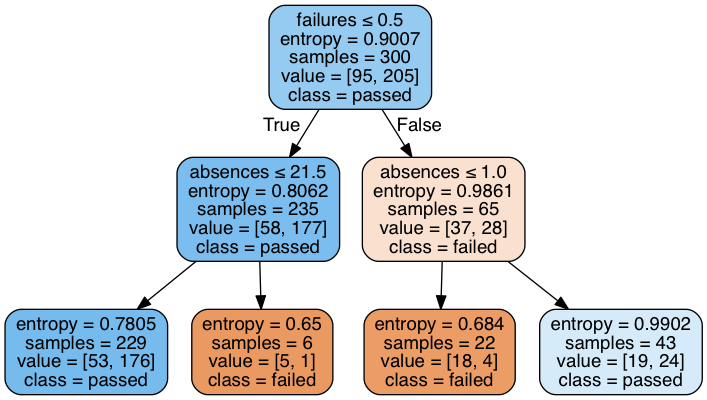

In [16]:
import sklearn.tree as treelib
from sklearn.externals.six import StringIO
import pydotplus
from IPython.display import Image


dot_data = StringIO()
treelib.export_graphviz(tree_fit, 
                        out_file=dot_data,
                        feature_names=list(X_all.columns),
                        class_names=['failed', 'passed'], filled=True, rounded=True,  
                         special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

**Answer: **
The F<sub>1</sub> score for training is 0.84 and testing is 0.79. The untuned model had more training accuracy which indicates overfitting. But, the tuned model beats untuned in testing. 

Following is comparison between different tuned classifiers:

In [17]:
df[df.tuned].groupby('classifier').test_f1.max()

classifier
AdaBoostClassifier            0.800000
BaggingClassifier             0.805556
DecisionTreeClassifier        0.786667
GaussianNB                    0.763359
GradientBoostingClassifier    0.797203
KNeighborsClassifier          0.791946
LogisticRegression            0.781457
RandomForestClassifier        0.774648
SGDClassifier                 0.774648
SVC                           0.794521
Name: test_f1, dtype: float64

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  
**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.